In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
def price_barrier_option(option_type, ticker, start, end, K, barrier_price, r=0.05, num_simulations=10000):
    # Descargar datos históricos
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    close = data['Close'].squeeze()
    daily_returns = close.pct_change().dropna()

    # Parámetros
    S0 = float(close.iloc[-1])                      # Precio actual del subyacente
    sigma = daily_returns.std() * np.sqrt(252)      # Volatilidad anualizada
    T_days = 252
    T = 1                                           # 1 año
    dt = T / T_days

    # Simulación de trayectorias (GBM)
    Z = np.random.normal(0, 1, (num_simulations, T_days))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S = S0 * np.exp(log_paths)
    S = np.concatenate([np.full((num_simulations, 1), S0), S], axis=1)

    # Barrera up-and-out
    barrier_breached = (S > barrier_price).any(axis=1)
    ST = S[:, -1]

    # Payoff
    if option_type == 'call':
        payoffs = np.where(~barrier_breached, np.maximum(ST - K, 0), 0)
    else:
        payoffs = np.where(~barrier_breached, np.maximum(K - ST, 0), 0)

    # Precio descontado
    price = np.exp(-r * T) * np.mean(payoffs)

    return float(S0), float(price)

In [3]:
# Ejemplo de uso
S0, price = price_barrier_option('call', 'SPY', '2022-01-01', '2025-10-15', K=680, barrier_price=700)
print(f"Precio actual del subyacente (S0): ${S0:.2f}")
print(f"Precio estimado de la opción barrera: {price:.4f}")

[*********************100%***********************]  1 of 1 completed

Precio actual del subyacente (S0): $662.23
Precio estimado de la opción barrera: 0.0249


---
**Ejercicio 1 – Sensibilidad al nivel de barrera**

Fija los parámetros:

option_type = 'call'

ticker = 'SPY'

K = 680

r = 0.05

Simula el precio de la opción para cinco niveles de barrera:
700, 710, 720, 730 y 740.

Muestra los resultados en una tabla y grafica:

Eje X: nivel de barrera.

Eje Y: precio estimado de la opción.

Pregunta guía: ¿Qué relación observas entre la altura de la barrera y el valor de la opción?

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


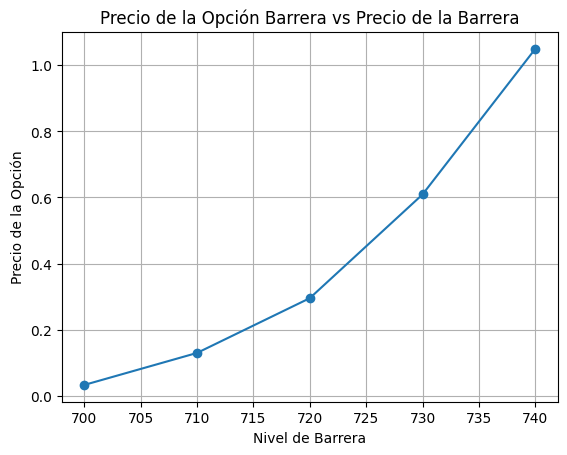

In [4]:
SB = [700, 710, 720, 730, 740]

prices = []

for i in SB:
    S0, option_price = price_barrier_option('call', 'SPY', '2022-01-01', '2025-10-15', K=680, barrier_price=i)
    prices.append(option_price)

plt.plot(SB, prices, marker='o')
plt.title('Precio de la Opción Barrera vs Precio de la Barrera')
plt.xlabel('Nivel de Barrera')
plt.ylabel('Precio de la Opción')
plt.grid()
plt.show()

A medida que aumenta el nivel de la barrera, el precio de la opción también incrementa. Cuando la barrera está más lejos del precio actual del activo subyacente, la probabilidad de que la opción se active (o deje de existir, dependiendo del tipo) disminuye, y por tanto su valor sube, acercándose al de una opción estándar sin barrera. Por el contrario, cuando la barrera está muy cerca del precio actual del activo, hay mayor probabilidad de activación o desactivación, lo que reduce el valor de la opción.

---
**Ejercicio 2 – Sensibilidad a la volatilidad**

Modifica la función para incluir un argumento sigma_override que permita reemplazar la volatilidad histórica.
Si sigma_override no es None, úsalo en lugar de daily_returns.std() * np.sqrt(252).

Evalúa el precio de la opción para cuatro niveles de volatilidad:
0.1, 0.2, 0.3 y 0.4.

Grafica cómo cambia el precio con la volatilidad. 

In [5]:
def price_barrier_option_vol_override(option_type, ticker, start, end, vol, K, barrier_price, r=0.05, num_simulations=10000):
    # Descargar datos históricos
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    close = data['Close'].squeeze()

    # Parámetros
    S0 = float(close.iloc[-1])                      # Precio actual del subyacente
    sigma = vol      # Volatilidad anualizada
    T_days = 252
    T = 1                                           # 1 año
    dt = T / T_days

    # Simulación de trayectorias (GBM)
    Z = np.random.normal(0, 1, (num_simulations, T_days))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S = S0 * np.exp(log_paths)
    S = np.concatenate([np.full((num_simulations, 1), S0), S], axis=1)

    # Barrera up-and-out
    barrier_breached = (S > barrier_price).any(axis=1)
    ST = S[:, -1]

    # Payoff
    if option_type == 'call':
        payoffs = np.where(~barrier_breached, np.maximum(ST - K, 0), 0)
    else:
        payoffs = np.where(~barrier_breached, np.maximum(K - ST, 0), 0)

    # Precio descontado
    price = np.exp(-r * T) * np.mean(payoffs)

    return float(price)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


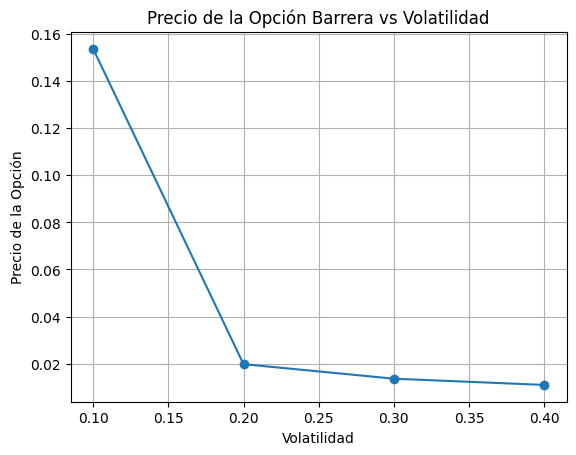

In [6]:
vol = [0.1, 0.2, 0.3, 0.4]

prices_vol = [price_barrier_option_vol_override('call', 'SPY', '2022-01-01', '2025-10-15', v, K=680, barrier_price=700) for v in vol]

plt.plot(vol, prices_vol, marker='o')
plt.title('Precio de la Opción Barrera vs Volatilidad')
plt.xlabel('Volatilidad')
plt.ylabel('Precio de la Opción')
plt.grid()
plt.show()

La volatilidad representa la incertidumbre o variabilidad esperada del precio del activo subyacente. Por lo tanto, cuando la volatilidad aumenta, existe mayor probabilidad de que el activo alcance la barrera, disminuyendo el precio de la opción (en el caso de un call como este).

---
**Ejercicio 3 – Comparación con una opción sin barrera**


Modifica el código para calcular el precio de una opción europea estándar (sin barrera).
Compara ambos precios (con y sin barrera) para los mismos parámetros.


Pregunta: ¿Por qué el precio de la opción barrera siempre debe ser menor o igual que el de una opción europea equivalente

In [7]:
def precio_europea(option_type, ticker, start, end, K, r=0.05, num_simulations=10000):
    # Descargar datos históricos
    data = yf.download(ticker, start=start, end=end, auto_adjust=True)
    close = data['Close'].squeeze()
    daily_returns = close.pct_change().dropna()

    # Parámetros
    S0 = float(close.iloc[-1])                      # Precio actual del subyacente
    sigma = daily_returns.std() * np.sqrt(252)      # Volatilidad anualizada
    T_days = 252
    T = 1                                           # 1 año
    dt = T / T_days

    # Simulación de trayectorias (GBM)
    Z = np.random.normal(0, 1, (num_simulations, T_days))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    S = S0 * np.exp(log_paths)
    S = np.concatenate([np.full((num_simulations, 1), S0), S], axis=1)
    ST = S[:, -1]

    # Payoff
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)

    # Precio descontado
    price = np.exp(-r * T) * np.mean(payoffs)

    return float(price)

In [8]:
price_eur = precio_europea('call', 'SPY', '2022-01-01', '2025-10-15', K=680)

results = {
    "Precio Opción Barrera": price,
    "Precio Opción Europea": price_eur
}

results

[*********************100%***********************]  1 of 1 completed


{'Precio Opción Barrera': 0.024906989188911047,
 'Precio Opción Europea': 54.65579958632611}

El resultado muestra que el precio de la opción barrera es menor que el de la opción europea estándar.

Esto ocurre porque una opción barrera tiene una restricción adicional: su valor depende no solo del precio final del activo, sino también de si el precio ha alcanzado o no un nivel de barrera durante la vida de la opción.
Esa condición introduce un riesgo adicional de desactivación (knock-out) o de que no se active (knock-in), lo que reduce la probabilidad de recibir un pago al vencimiento en comparación con una opción europea tradicional.